# Import Libraries

In [102]:


import cv2
from ultralytics import YOLO
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import json
import math
from IPython.display import display, Image
import statistics
import random
import torch
from ultralytics import YOLO
from scipy.stats import mode


# Yolo Detecting Object

Using cache found in C:\Users\Admin/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-4-20 Python-3.11.9 torch-2.2.2+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


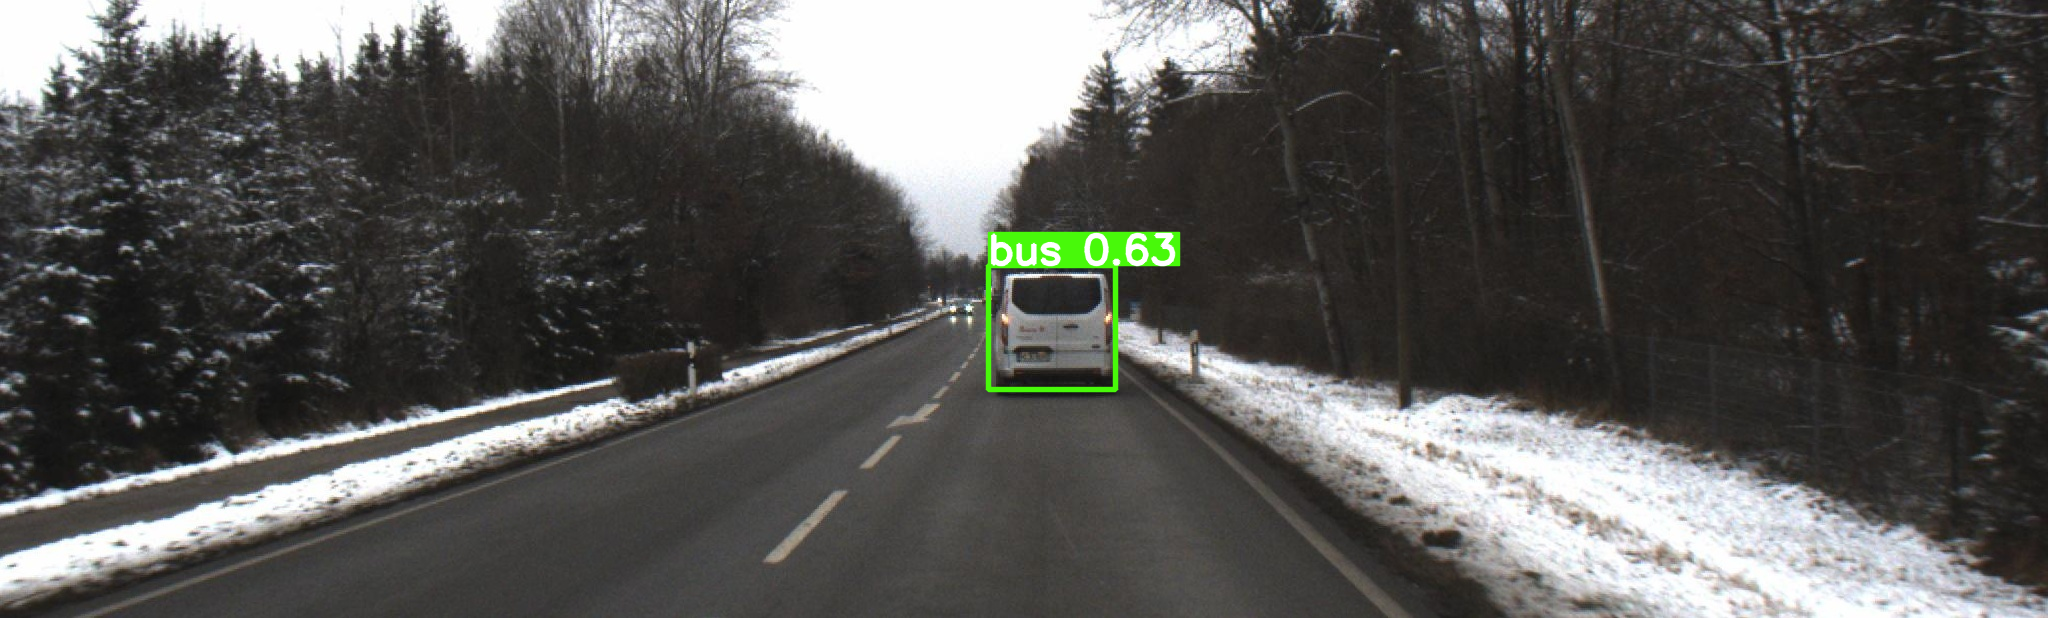

In [72]:
# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Images
imgs = ['./dataset_astyx_hires2019/dataset_astyx_hires2019/camera_front/000131.jpg']  # batch of images

# Inference
results = model(imgs)

# Show detected objects
results.show()
results.xyxy[0]  # img1 predictions (tensor)
df = results.pandas().xyxy[0]

# Define output path
output_path = './dataset_astyx_hires2019/dataset_astyx_hires2019/BB_Coordinates/000131.csv'

# Save DataFrame to CSV
df.to_csv(output_path, index=False)

# Class Calculation

In [73]:
class calib_astyx():
    def __init__(self, file):
        # Initialize the calibration object by loading sensor calibration data from a JSON file.
        # Parameters:
        # - file: A string path to the JSON file containing calibration data for radar, lidar, and camera sensors.

        # Load calibration data from a JSON file
        with open(file) as json_file:
            data = json.load(json_file)
            
        # Calibration matrices for converting radar, lidar, and camera data to a reference coordinate system
        self.radar2ref = np.array(data["sensors"][0]["calib_data"]["T_to_ref_COS"])  # Radar to reference
        self.lidar2ref_cos = np.array(data["sensors"][1]["calib_data"]["T_to_ref_COS"])  # Lidar to reference (COS means Coordinate System)
        self.camera2ref = np.array(data["sensors"][2]["calib_data"]["T_to_ref_COS"])  # Camera to reference
        self.K = np.array(data["sensors"][2]["calib_data"]["K"])  # Intrinsic camera matrix
        
        # Compute inverse transformations for mapping from the reference coordinate system back to sensor-specific coordinate systems
        self.ref2radar = self.inv_trans(self.radar2ref)
        self.ref2lidar = self.inv_trans(self.lidar2ref_cos)
        self.ref2camera = self.inv_trans(self.camera2ref)

    @staticmethod
    def inv_trans(T):
        # Compute the inverse transformation matrix for a given sensor to reference coordinate transformation.
        # Parameters:
        # - T: A numpy array representing the transformation matrix from sensor to reference coordinates.
        # Returns:
        # - The inverse transformation matrix as a numpy array, which can be used to map points from the
        # reference coordinate system back to the sensor-specific coordinate system.

        rotation = np.linalg.inv(T[0:3, 0:3])  # Invert the rotation part
        translation = T[0:3, 3]
        translation = -1 * np.dot(rotation, translation.T)  # Invert the translation part
        translation = np.reshape(translation, (3, 1))
        Q = np.hstack((rotation, translation))  # Reassemble the inverted transformation matrix

        return Q


    def lidar2ref(self, points):
        # Convert lidar points from the lidar coordinate system to the reference coordinate system.
        # Parameters:
        # - points: A numpy array of points in the lidar coordinate system.
        # Returns:
        # - A numpy array of the same points transformed to the reference coordinate system.

        n = points.shape[0]
        
        points_hom = np.hstack((points, np.ones((n,1))))  # Convert points to homogeneous coordinates
        points_ref = np.dot(points_hom, np.transpose(self.lidar2ref_cos))  # Transform points to reference coordinate system
        
        return points_ref[:,0:3]  # Return the transformed points, discarding the homogeneous coordinate
    
    def radar2ref(self, points):
        """
        Convert radar points from the radar coordinate system to the reference coordinate system.
        Parameters:
        - points: A numpy array of points in the radar coordinate system.
        Returns:
        - A numpy array of the same points transformed to the reference coordinate system.
        """
        n = points.shape[0]
        points_hom = np.hstack((points, np.ones((n, 1))))  # Convert points to homogeneous coordinates
        points_ref = np.dot(points_hom, np.transpose(self.radar2ref))  # Transform points to reference coordinate system
        return points_ref[:, 0:3]  # Return the transformed points, discarding the homogeneous coordinate


    def ref2Camera(self, points, img_size):
        # Project points from the reference coordinate system onto the camera image plane.
        # Parameters:
        # - points: A numpy array of points in the reference coordinate system.
        # - img_size: A tuple representing the size of the camera image (width, height).
        # Returns:
        # - A tuple containing a numpy array of the projected points on the camera image plane and a mask
        # array indicating which points are within the image frame.

        obj_image = np.dot(self.ref2camera[0:3, 0:3], points.T)  # Apply rotation
        T = self.ref2camera[0:3, 3]
        obj_image = obj_image + T[:, np.newaxis]  # Apply translation
        obj_image = np.dot(self.K, obj_image)  # Apply intrinsic camera matrix
        obj_image = obj_image / obj_image[2]  # Normalize by the third row to project onto image plane
        obj_image = np.delete(obj_image, 2, 0)  # Remove the third row
        
        # Create a mask to filter out points that are outside the image frame or behind the camera
        mask = (obj_image[0,:] <= img_size[0]) & \
               (obj_image[1,:] <= img_size[1]) & \
               (obj_image[0,:] >= 0) & (obj_image[1,:] >= 0) & \
               (points[:,0] >= 0)
        return obj_image, mask  # Return the projected points and the mask


# Object Calculation

In [74]:
class Object3d(object):
    """
    Represents a 3D object with attributes extracted from a given input dictionary.
    This class handles the extraction and manipulation of various object properties,
    including its orientation, bounding box, and angle calculations based on quaternion
    orientation data.

    Attributes:
    - type (str): The class name of the object.
    - occlusion (float): The occlusion level of the object.
    - quat (numpy.ndarray): Quaternion representing the object's orientation.
    - rotationmatrix (numpy.ndarray): Rotation matrix derived from the quaternion.
    - h (float): Height of the object's bounding box.
    - w (float): Width of the object's bounding box.
    - l (float): Length of the object's bounding box.
    - t (tuple): A tuple representing the center of the object's bounding box.
    - distance (float): Distance of the object from the origin, calculated using its bounding box center.
    - bbox (numpy.ndarray): Coordinates of the object's bounding box corners.
    - angle (float): Angle of the object's orientation in degrees.
    """
    def __init__(self, obj):
        """
        Initializes an Object3d instance by extracting relevant attributes from the input dictionary.

        Parameters:
        - obj (dict): A dictionary containing object properties, including its class name,
                      dimensions, center, occlusion level, and orientation quaternion.
        """
        # Extract basic attributes
        self.type = obj["classname"]
        self.occlusion = obj["occlusion"] 
        self.quat = np.array(obj["orientation_quat"])
        self.rotationmatrix = self.get_rotationmatrix()
        
        # Extract 3D bounding box information
        self.h = obj["dimension3d"][2]  # box height
        self.w = obj["dimension3d"][1]  # box width
        self.l = obj["dimension3d"][0]  # box length (in meters)
        self.t = (obj["center3d"][0], obj["center3d"][1], obj["center3d"][2])
        
        self.distance = np.sqrt(np.sum(np.square(self.t)))
        
        # Calculate bounding box corners and object's angle
        self.bbox = self.get_bbox()
        self.angle = self.get_angle()[2]
        if self.angle >= 0:
            self.angle = self.angle * 180 / np.pi
        else:
            self.angle = self.angle * 180 / np.pi + 360

    def get_angle(self):
        """
        Calculates the Euler angles from the object's orientation quaternion.

        Returns:
        - A tuple of Euler angles (roll, pitch, yaw) in radians.
        """
        w, x, y, z = self.quat
        return (math.atan2(2*(w*x+y*z), 1-2*(x*x+y*y)),
                math.asin(2*(w*y-z*x)),
                math.atan2(2*(w*z+x*y), 1-2*(y*y+z*z)))

    def get_bbox(self):
        """
        Calculates the coordinates of the object's bounding box corners based on its
        center, dimensions, and orientation.

        Returns:
        - A numpy.ndarray containing the coordinates of the bounding box corners.
        """
        center = np.array(self.t)
        dimension = np.array([self.l, self.w, self.h])

        # Adjust dimensions for bounding box calculation
        w, l, h = dimension[0] + 0.1, dimension[1] + 0.1, dimension[2]

        # Define corner points in local object coordinates
        x_corners = [-w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2, w / 2]
        y_corners = [l / 2, -l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2]
        z_corners = [h / 2, h / 2, h / 2, -h / 2, -h / 2, -h / 2, -h / 2, h / 2]

        # Apply rotation and translate to global coordinates
        R = self.rotationmatrix
        bbox = np.vstack([x_corners, y_corners, z_corners])
        bbox = np.dot(R, bbox)
        bbox = bbox + center[:, np.newaxis]
        bbox = np.transpose(bbox)

        return bbox
    
    def get_rotationmatrix(self):
        """
        Converts the object's orientation quaternion into a rotation matrix.

        Returns:
        - A numpy.ndarray representing the rotation matrix.
        """
        n = np.dot(self.quat, self.quat)
        if n < np.finfo(self.quat.dtype).eps:
            return np.identity(4)  # Return identity matrix if quaternion is near zero
        
        q = self.quat * np.sqrt(2.0 / n)
        q = np.outer(q, q)
        rot_matrix = np.array(
            [[1.0 - q[2, 2] - q[3, 3], q[1, 2] + q[3, 0], q[1, 3] - q[2, 0]],
             [q[1, 2] - q[3, 0], 1.0 - q[1, 1] - q[3, 3], q[2, 3] + q[1, 0]],
             [q[1, 3] + q[2, 0], q[2, 3] - q[1, 0], 1.0 - q[1, 1] - q[2, 2]]],
            dtype=q.dtype)
        rot_matrix = np.transpose(rot_matrix)
        return rot_matrix

class calib_astyx():
    """
    This class is designed to manage the calibration of sensor data in autonomous vehicle contexts.
    
    It supports the conversion of sensor data between different coordinate systems, specifically for radar,
    lidar, and camera sensors, to a common reference coordinate system and vice versa. It also handles the
    projection of points from the reference coordinate system onto the camera image plane.
    """
    
    def __init__(self, file):
        """
        Initialize the calibration object by loading sensor calibration data from a JSON file.
        
        Parameters:
        - file: A string path to the JSON file containing calibration data for radar, lidar, and camera sensors.
        
        The method extracts transformation matrices for each sensor to the reference coordinate system and
        the intrinsic camera matrix.
        """
        # Load calibration data from a JSON file
        with open(file) as json_file:
            data = json.load(json_file)
            
        # Calibration matrices for converting radar, lidar, and camera data to a reference coordinate system
        self.radar2ref_cos = np.array(data["sensors"][0]["calib_data"]["T_to_ref_COS"])  # Radar to reference
        self.lidar2ref_cos = np.array(data["sensors"][1]["calib_data"]["T_to_ref_COS"])  # Lidar to reference (COS means Coordinate System)
        self.camera2ref = np.array(data["sensors"][2]["calib_data"]["T_to_ref_COS"])  # Camera to reference
        self.K = np.array(data["sensors"][2]["calib_data"]["K"])  # Intrinsic camera matrix
        
        # Compute inverse transformations for mapping from the reference coordinate system back to sensor-specific coordinate systems
        self.ref2radar = self.inv_trans(self.radar2ref_cos)
        self.ref2lidar = self.inv_trans(self.lidar2ref_cos)
        self.ref2camera = self.inv_trans(self.camera2ref)

    @staticmethod
    def inv_trans(T):
        """
        Compute the inverse transformation matrix for a given sensor to reference coordinate transformation.
        
        Parameters:
        - T: A numpy array representing the transformation matrix from sensor to reference coordinates.
        
        Returns:
        - The inverse transformation matrix as a numpy array, which can be used to map points from the
          reference coordinate system back to the sensor-specific coordinate system.
        """
        rotation = np.linalg.inv(T[0:3, 0:3])  # Invert the rotation part
        translation = T[0:3, 3]
        translation = -1 * np.dot(rotation, translation.T)  # Invert the translation part
        translation = np.reshape(translation, (3, 1))
        Q = np.hstack((rotation, translation))  # Reassemble the inverted transformation matrix

        return Q
    
    def lidar2ref(self, points):
        """
        Convert lidar points from the lidar coordinate system to the reference coordinate system.
        
        Parameters:
        - points: A numpy array of points in the lidar coordinate system.
        
        Returns:
        - A numpy array of the same points transformed to the reference coordinate system.
        """
        n = points.shape[0]
        
        points_hom = np.hstack((points, np.ones((n,1))))  # Convert points to homogeneous coordinates
        points_ref = np.dot(points_hom, np.transpose(self.lidar2ref_cos))  # Transform points to reference coordinate system
        
        return points_ref[:,0:3]  # Return the transformed points, discarding the homogeneous coordinate
    
    def radar2ref(self, points):
        # Convert radar points from the radar coordinate system to the reference coordinate system.
        # Parameters:
        # - points: A numpy array of points in the radar coordinate system.
        # Returns:
        # - A numpy array of the same points transformed to the reference coordinate system.

        n = points.shape[0]
        
        points_hom = np.hstack((points, np.ones((n,1))))  # Convert points to homogeneous coordinates
        points_ref = np.dot(points_hom, np.transpose(self.radar2ref_cos))  # Transform points to reference coordinate system
        
        return points_ref[:,0:3]  # Return the transformed points, discarding the homogeneous coordinate

    def ref2Camera(self, points, img_size):
        """
        Project points from the reference coordinate system onto the camera image plane.
        
        Parameters:
        - points: A numpy array of points in the reference coordinate system.
        - img_size: A tuple representing the size of the camera image (width, height).
        
        Returns:
        - A numpy array of projected points on the camera image plane.
        - A boolean mask indicating whether each point is visible in the camera image.
        """
        n = points.shape[0]
        
        # Convert points to homogeneous coordinates
        points_hom = np.hstack((points, np.ones((n,1))))
        
        # Transform points to camera coordinate system
        points_camera = np.dot(points_hom, np.transpose(self.ref2camera))
        
        # Project points onto camera image plane
        projected_points = np.dot(points_camera, np.transpose(self.K))
        projected_points = projected_points[:, 0:2] / projected_points[:, 2][:, None]
        
        # Create mask to filter out points outside the image boundaries
        mask = (projected_points[:, 0] >= 0) & (projected_points[:, 0] < img_size[0]) & \
               (projected_points[:, 1] >= 0) & (projected_points[:, 1] < img_size[1])
        
        return projected_points, mask


# LIdar Point Converstion To Image

In [75]:
# Load calibration data
calib = calib_astyx("./dataset_astyx_hires2019/dataset_astyx_hires2019/calibration/000131.json")

# Load lidar data from text file
lidar = np.loadtxt("./dataset_astyx_hires2019/dataset_astyx_hires2019/lidar_vlp16/000131.txt", skiprows=1)

lidar_points = lidar[:, :3]  # Selecting only the first three points
lidar_points_ref = calib.lidar2ref(lidar_points)
#print(lidar_points_ref)

# Load camera image using OpenCV
img = cv2.imread("./dataset_astyx_hires2019/dataset_astyx_hires2019/camera_front/000131.jpg")  

# Get the height and width of the image
img_height, img_width = img.shape[:2]

# Project lidar points onto camera image
projected_points, mask = calib.ref2Camera(lidar_points_ref, (img_width, img_height))



# Dispaly Lidar Point in Image 

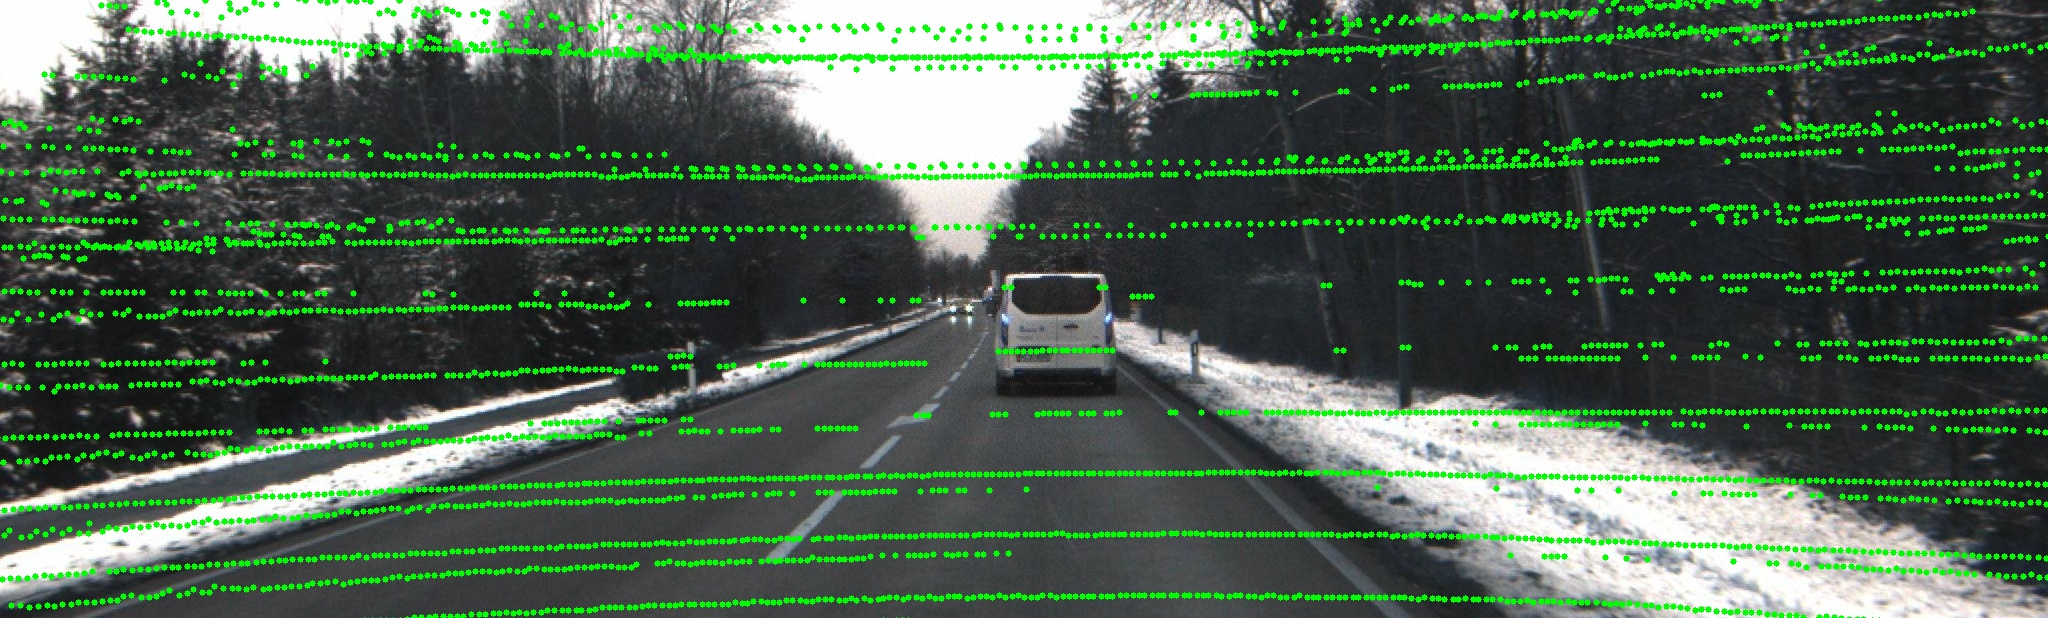

In [76]:
# Convert projected points to integers for pixel coordinates
projected_points_int = projected_points.astype(int)


# Draw projected lidar points on the image
for point in projected_points_int:
    cv2.circle(img, (point[0], point[1]), radius=3, color=(0, 255, 0), thickness=-1)

# Convert OpenCV image to RGB format
img_rgb_l = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image
display(Image(data=cv2.imencode('.jpg', img_rgb_l)[1]))


# Filtearing Lidar Point

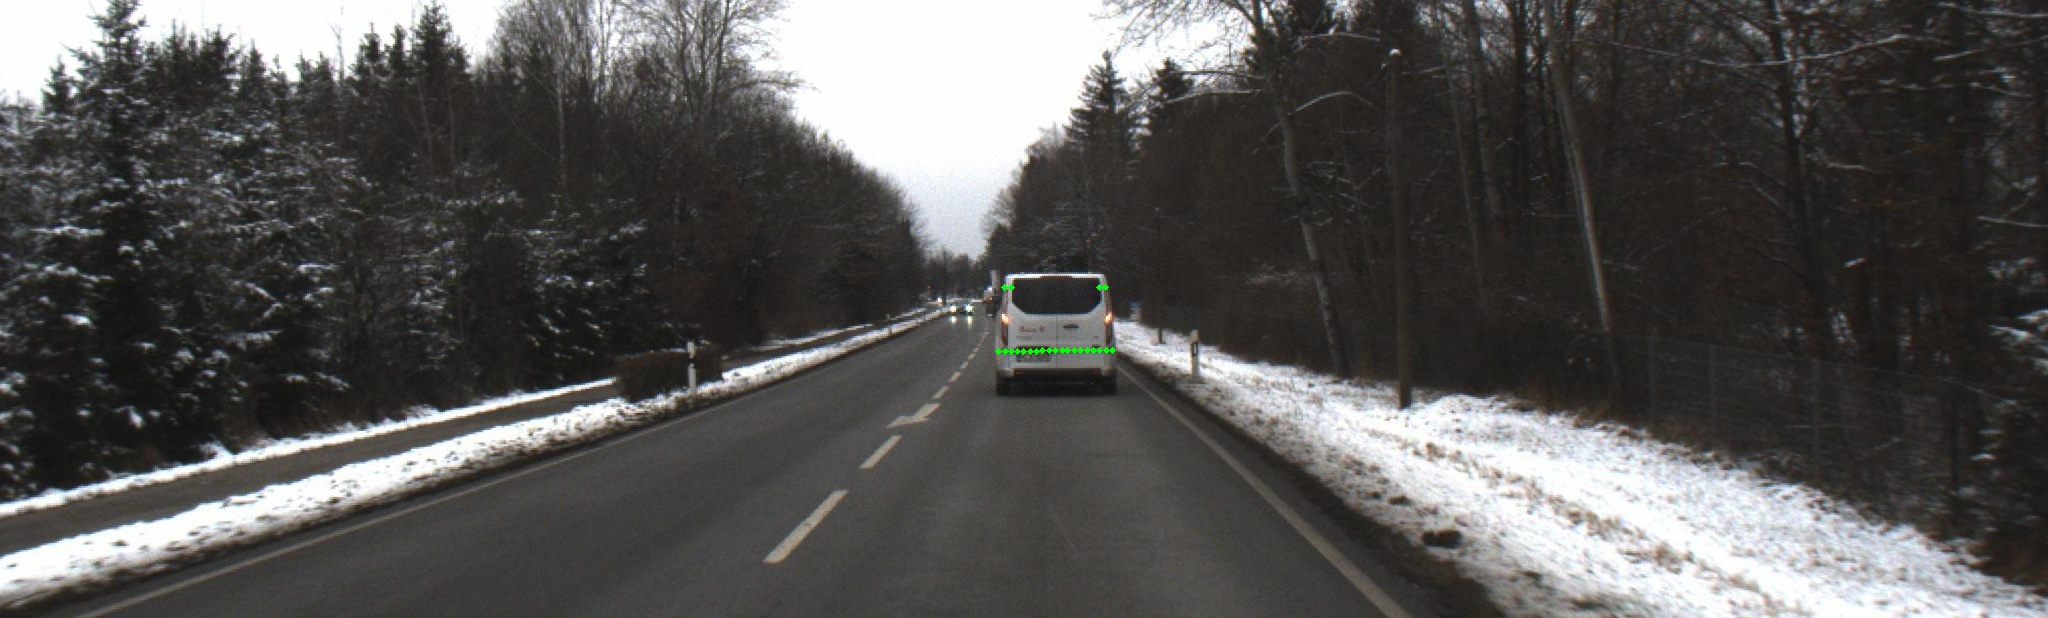

In [77]:
bbox_data = pd.read_csv(r"./dataset_astyx_hires2019/dataset_astyx_hires2019/BB_Coordinates/000131.csv")

img_lidar=cv2.imread(r'./dataset_astyx_hires2019/dataset_astyx_hires2019/camera_front/000131.jpg')
# Store bounding box coordinates
BB_Coor = bbox_data[['xmin', 'ymin', 'xmax', 'ymax']].values

# Read lidar projected points
lidar_points = projected_points_int  # Assuming you already have this variable
# Store lidar projected points
Lidar_Fil = lidar_points.copy()

# Compare bounding box coordinates and lidar points
Fused_BB_Li = []
for point in Lidar_Fil:
    x, y = point[:2]
    for xmin, ymin, xmax, ymax in BB_Coor:
        if xmin <= x <= xmax and ymin <= y <= ymax:
            Fused_BB_Li.append(point)
            break

# Store the filtered lidar points in Fused_BB_Li
Fused_BB_Li = np.array(Fused_BB_Li)

# Draw lidar points inside bounding box on copied image
for point in Fused_BB_Li:
    cv2.circle(img_lidar, (point[0], point[1]), radius=1, color=(0, 255, 0), thickness=3)

# Display the image with filtered lidar points inside the bounding box
display(Image(data=cv2.imencode('.jpg', img_lidar)[1]))

# Conversion of Radar point onto Image

In [78]:
# Load calibration data
calib = calib_astyx("./dataset_astyx_hires2019/dataset_astyx_hires2019/calibration/000131.json")

# Load lidar data from text file
radar = np.loadtxt("./dataset_astyx_hires2019/dataset_astyx_hires2019/radar_6455/000131.txt", skiprows=2)

radar_points = radar[:, :3]  # Selecting only the first three points
radar_points_ref = calib.radar2ref(radar_points)

# Load camera image using OpenCV
imgage = cv2.imread("./dataset_astyx_hires2019/dataset_astyx_hires2019/camera_front/000131.jpg")  

# Get the height and width of the image
img_height, img_width = imgage.shape[:2]

# Project lidar points onto camera image
projected_points, mask = calib.ref2Camera(radar_points_ref, (img_width, img_height))



# Dispalying Radar Point onto Image

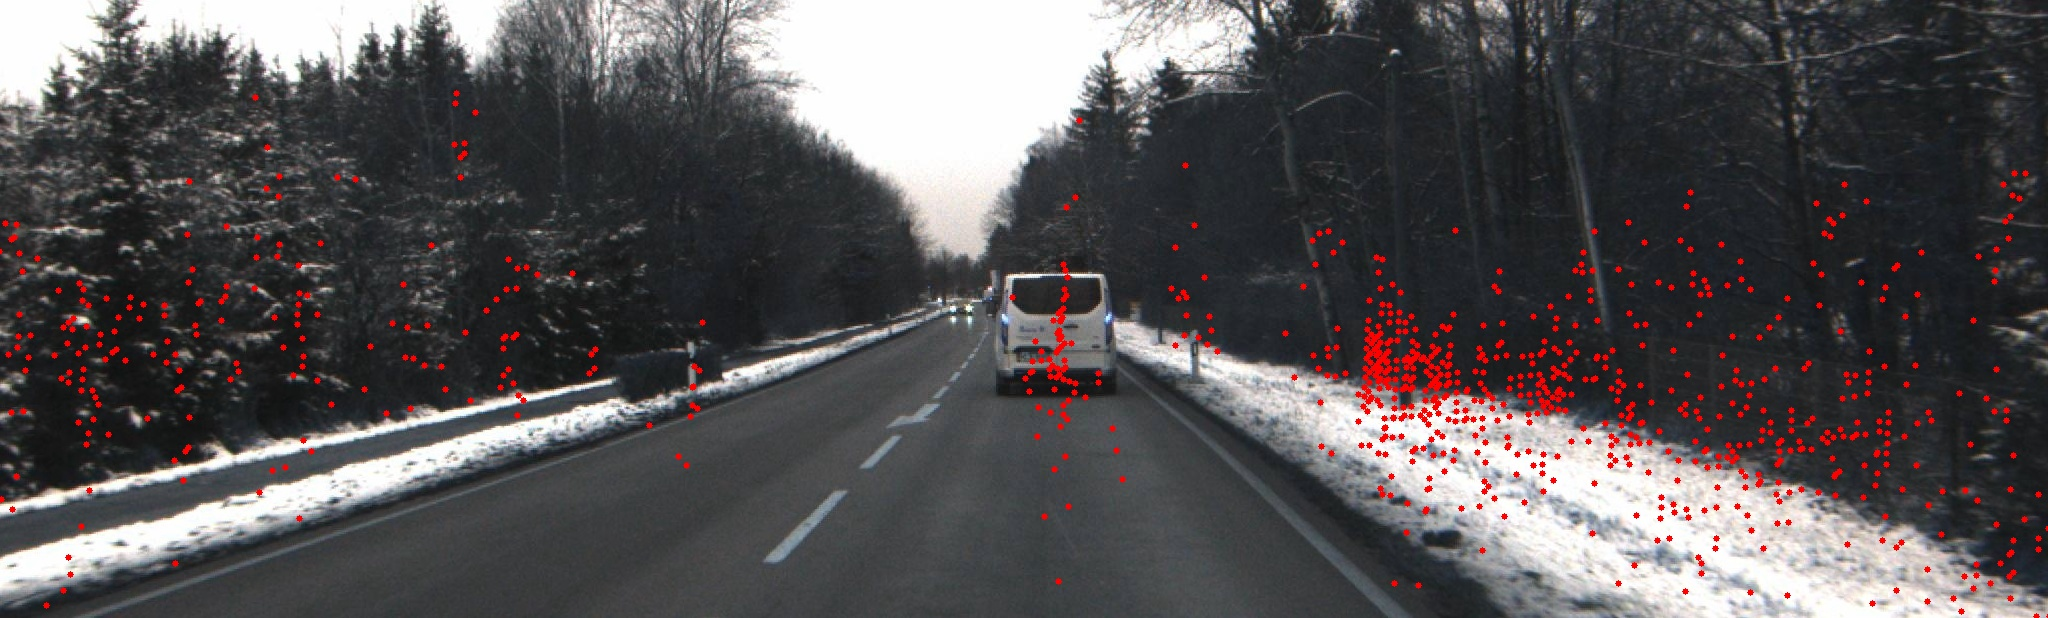

In [79]:


# Convert projected points to integers for pixel coordinates
projected_points_int_radar = projected_points.astype(int)

# Draw projected lidar points on the image
for point in projected_points_int_radar:
    cv2.circle(imgage, (point[0], point[1]), radius=3, color=(255, 0, 0), thickness=-1)

# Convert OpenCV image to RGB format
img_rgb_r = cv2.cvtColor(imgage, cv2.COLOR_BGR2RGB)

# Display the image
display(Image(data=cv2.imencode('.jpg', img_rgb_r)[1]))

# Filtering radar Points

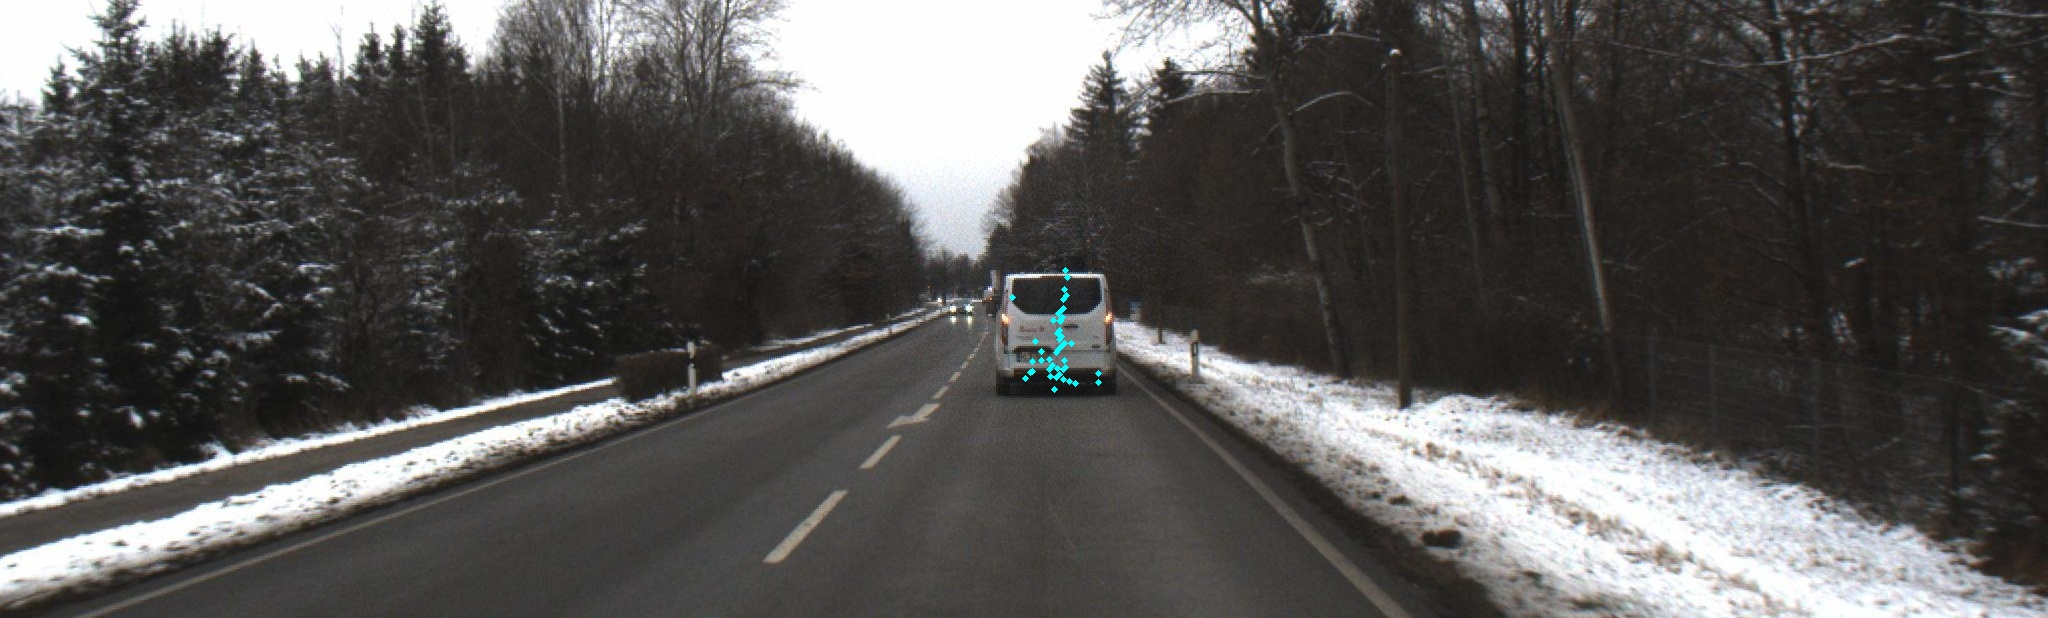

In [80]:
bbox_data = pd.read_csv(r"./dataset_astyx_hires2019/dataset_astyx_hires2019/BB_Coordinates/000131.csv")

img_radar=cv2.imread(r'./dataset_astyx_hires2019/dataset_astyx_hires2019/camera_front/000131.jpg')

# Store bounding box coordinates
BB_Coor = bbox_data[['xmin', 'ymin', 'xmax', 'ymax']].values

# Read radar projected points
radar_points = projected_points_int_radar  # Assuming you already have this variable

# Store Radar projected points
Radar_Fil = radar_points.copy()

# Compare bounding box coordinates and lidar points
Fused_BB_RA = []
for point in Radar_Fil:
    x, y = point[:2]
    for xmin, ymin, xmax, ymax in BB_Coor:
        if xmin <= x <= xmax and ymin <= y <= ymax:
            Fused_BB_RA.append(point)
            break

# Store the filtered lidar points in Fused_BB_Li
Fused_BB_RA = np.array(Fused_BB_RA)


# Draw lidar points inside bounding box on copied image
for point in Fused_BB_RA:
    cv2.circle(img_radar, (point[0], point[1]), radius=1, color=(255, 255, 0), thickness=3)

# Display the image with filtered lidar points inside the bounding box
display(Image(data=cv2.imencode('.jpg', img_radar)[1]))

# Blended Lidar And Radar Point in one Image

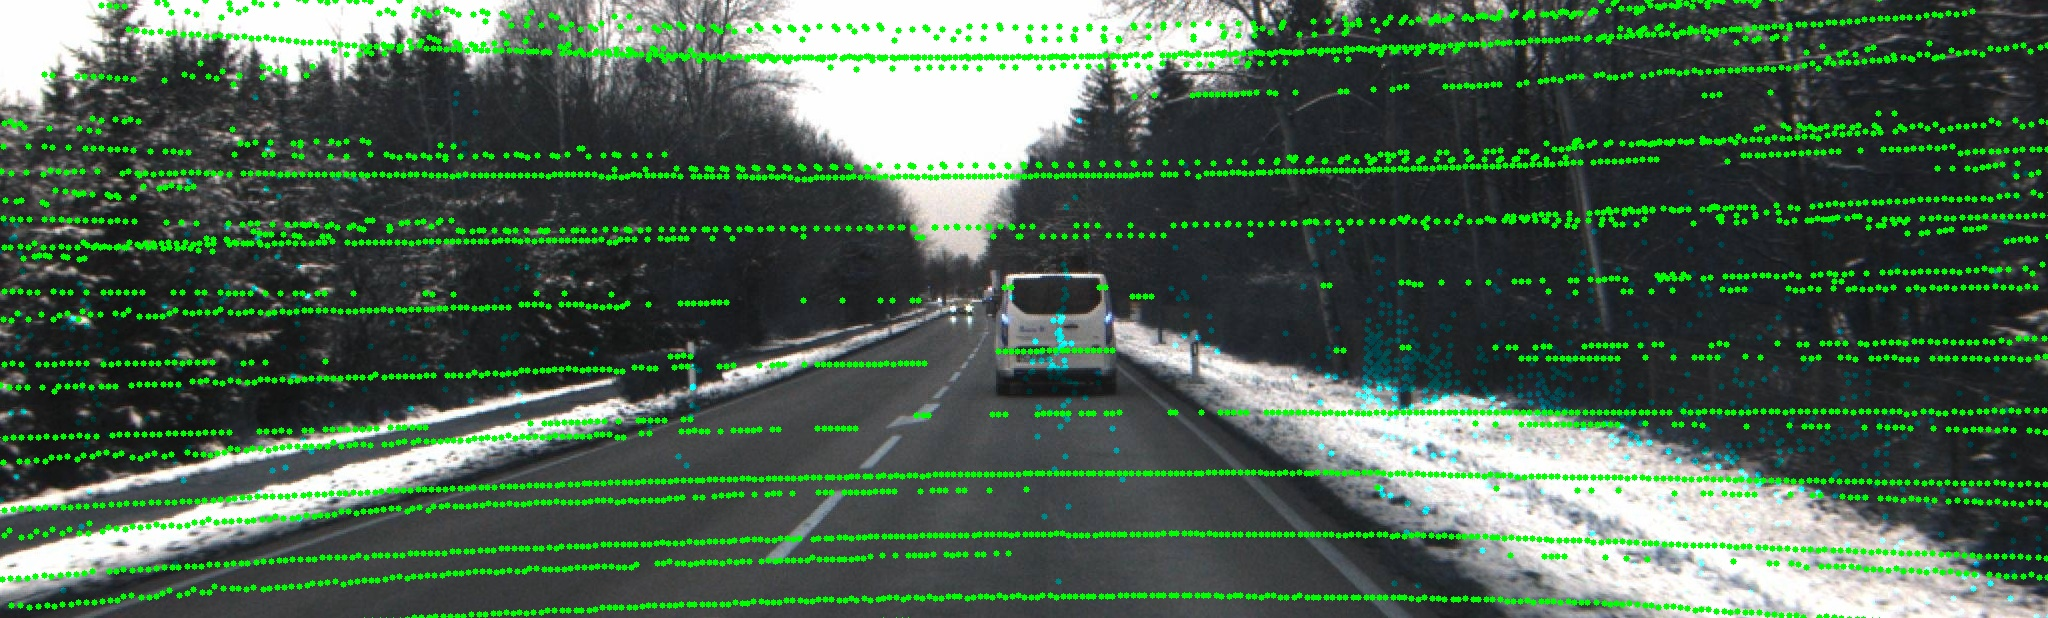

In [81]:
# Blend the images using alpha blending
alpha = 2  # Adjust the alpha value for blending
blended_img = cv2.addWeighted(img_rgb_l, alpha, img_rgb_r, 1 - alpha, 0)

# Display the blended image
display(Image(data=cv2.imencode('.jpg', blended_img)[1]))

# Filter Radar and Lidar Fused point

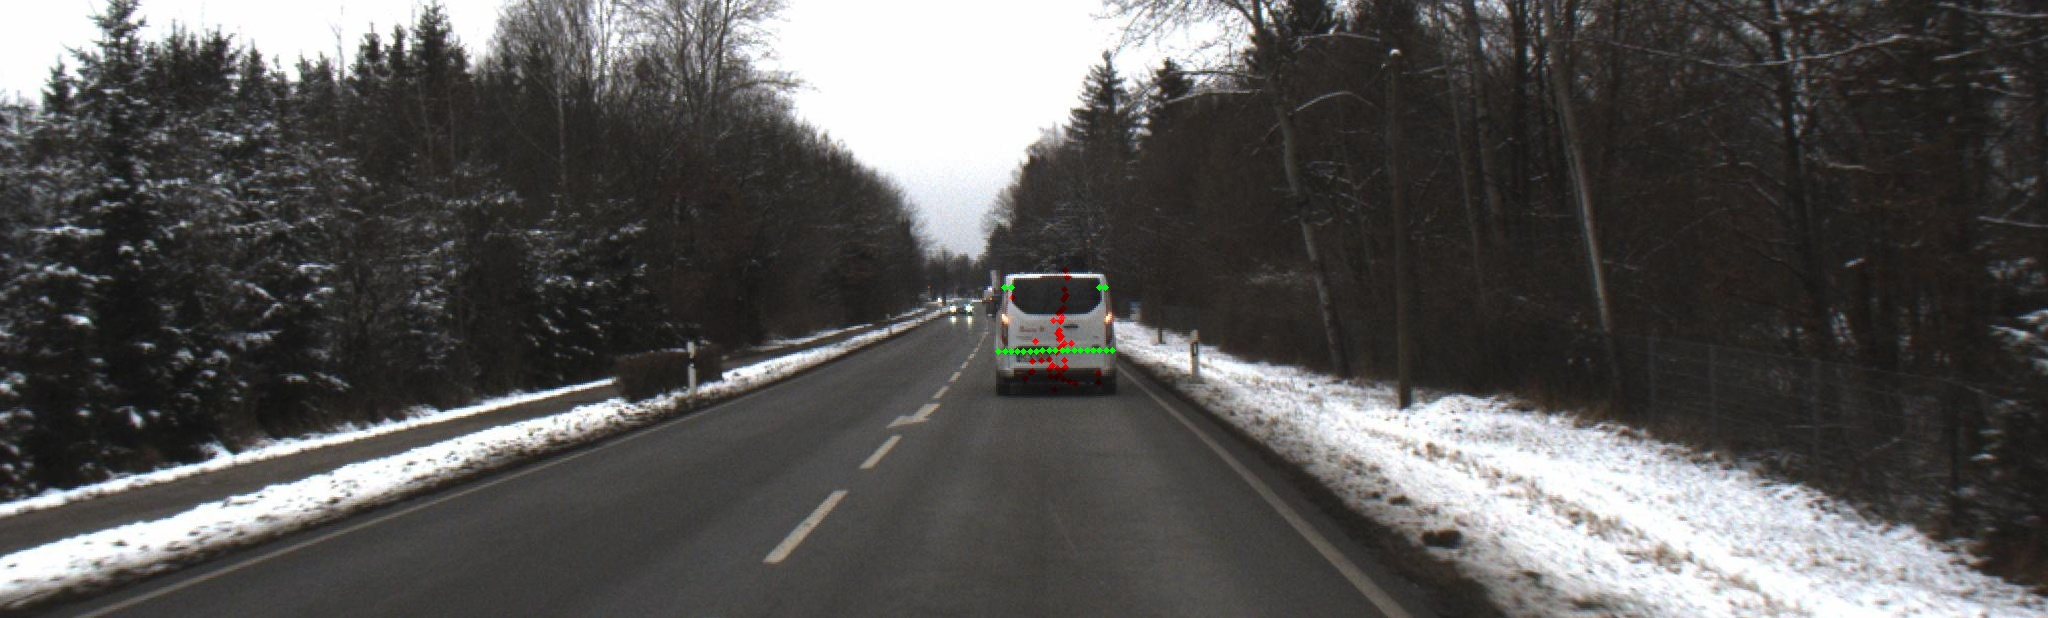

In [82]:
# Blend the images using alpha blending
alpha = 2  # Adjust the alpha value for blending
blended_img_li_ra = cv2.addWeighted(img_lidar, alpha, img_radar, 1 - alpha, 0)

# Display the blended image
display(Image(data=cv2.imencode('.jpg', blended_img_li_ra)[1]))

# Distance Estimation Lidar and Radar

# Lidar Distance Estimation

In [83]:
# Load lidar data from text file
lidar_v = np.loadtxt("./dataset_astyx_hires2019/dataset_astyx_hires2019/lidar_vlp16/000131.txt", skiprows=1)

# Store lidar points in Lidar_d
Lidar_d = lidar_v[:, :3]

# Transform lidar points to the reference coordinate system
lidar_d_ref = calib.lidar2ref(Lidar_d)

# Print the transformed lidar points (Refrence co-ordinates)
#print(lidar_d_ref)

# Project lidar points onto camera image
projected_points, mask = calib.ref2Camera(lidar_d_ref, (img_width, img_height))

# Convert projected points to integers for pixel coordinates
Lidar_d_2d = projected_points.astype(int)
#print(Lidar_d_2d)

BB = pd.read_csv(r"./dataset_astyx_hires2019/dataset_astyx_hires2019/BB_Coordinates/000131.csv")

# Extract bounding box coordinates from DataFrame
BB_Coordinates = bbox_data[['xmin', 'ymin', 'xmax', 'ymax']].values
#print(BB_Coordinates)

# Initialize list to store filtered lidar points
lidar_fildistance = []

# Compare bounding box coordinates and lidar points
for point in Lidar_d_2d:
    x, y = point[:2]
    for xmin, ymin, xmax, ymax in BB_Coordinates:
        if xmin <= x <= xmax and ymin <= y <= ymax:
            lidar_fildistance.append(point)
            break

# Convert filtered lidar points to NumPy array
lidar_fildistance = np.array(lidar_fildistance)

#print(lidar_fildistance)




# Store Correspoinding Lidar Points (X,Y,Z)

In [84]:
# Initialize list to store corresponding lidar points
com_lidar = []

# Iterate through each pixel coordinate in lidar_fildistance
for u, v in lidar_fildistance:
    # Find the corresponding index in the original lidar points array based on the pixel coordinates
    # Assuming Lidar_d_2d contains the original lidar points projected onto the image plane
    index = np.where((Lidar_d_2d[:, 0] == u) & (Lidar_d_2d[:, 1] == v))[0][0]

    # Retrieve the corresponding lidar point (X, Y, Z) from the original lidar data
    x, y, z = Lidar_d[index]

    # Append the combined lidar point (X, Y, Z) to com_lidar
    com_lidar.append([x, y, z])

# Convert list of combined lidar points to NumPy array
com_lidar = np.array(com_lidar)

#print(com_lidar)


# Lidar Medain

In [120]:
# Extract X coordinates from com_lidar
x_coordinates_lidar = com_lidar[:, 0]

# Calculate the median of X coordinates for lidar
x_median_lidar = np.median(x_coordinates_lidar)

print("Median of X coordinates for lidar:", x_median_lidar)

# Define a custom function to calculate the mode
def calculate_mode(arr):
    unique_elements, counts = np.unique(arr, return_counts=True)
    mode_index = np.argmax(counts)
    mode_value = unique_elements[mode_index]
    return mode_value

# Assuming com_lidar is a NumPy array containing X coordinates in the first column
x_coordinates_lidar = com_lidar[:, 0]

# Calculate the mode of X coordinates for Lidar
x_lidar_mode = calculate_mode(x_coordinates_lidar)

print("Mode of X coordinates for Lidar:", x_lidar_mode)

# Round the mode value to two decimal places
x_lidar_mode_rounded = round(x_lidar_mode, 3)

# Print the rounded mode value
print("Rounded mode of X coordinates for Lidar:", x_lidar_mode_rounded)



Median of X coordinates for lidar: 28.72
Mode of X coordinates for Lidar: 28.65
Rounded mode of X coordinates for Lidar: 28.65


# Radar Distance Estimation

In [86]:
# Load radar data from text file
radar_data = np.loadtxt("./dataset_astyx_hires2019/dataset_astyx_hires2019/radar_6455/000131.txt", skiprows=2)


# Store radar points in radar_points variable
radar_points = radar_data[:, :3]

# Transform radar points to the reference coordinate system
radar_points_ref = calib.radar2ref(radar_points)

# Project radar points onto camera image
projected_points, mask = calib.ref2Camera(radar_points_ref, (img_width, img_height))

# Convert projected points to integers for pixel coordinates
radar_points_2d = projected_points.astype(int)
#print(radar_points_2d)

BB = pd.read_csv(r"./dataset_astyx_hires2019/dataset_astyx_hires2019/BB_Coordinates/000131.csv")

# Extract bounding box coordinates from DataFrame
BB_Coordinates = BB[['xmin', 'ymin', 'xmax', 'ymax']].values

# Initialize list to store filtered radar points
filtered_radar_points = []

# Compare bounding box coordinates and radar points
for point in radar_points_2d:
    x, y = point[:2]
    for xmin, ymin, xmax, ymax in BB_Coordinates:
        if xmin <= x <= xmax and ymin <= y <= ymax:
            filtered_radar_points.append(point)
            break

# Convert filtered radar points to NumPy array
filtered_radar_points = np.array(filtered_radar_points)

#print(filtered_radar_points)



# Store Correspoing Radar Points(X,Y,Z)

In [87]:
# Initialize list to store corresponding radar points
com_radar = []

# Iterate through each pixel coordinate in filtered_radar_points
for u, v in filtered_radar_points:
    # Find the corresponding index in the original radar points array based on the pixel coordinates
    # Assuming radar_points_2d contains the original radar points projected onto the image plane
    index = np.where((radar_points_2d[:, 0] == u) & (radar_points_2d[:, 1] == v))[0][0]

    # Retrieve the corresponding radar point (X, Y, Z) from the original radar data
    x, y, z = radar_points[index]

    # Append the combined radar point (X, Y, Z) to com_radar
    com_radar.append([x, y, z])

# Convert list of combined radar points to NumPy array
com_radar = np.array(com_radar)

#print(com_radar)


# Medain and Mode Radar Points

In [119]:
# Extract X coordinates from com_radar
x_coordinates_radar = com_radar[:, 0]

# Calculate the median of X coordinates for radar
x_radar = np.median(x_coordinates_radar)

print("Median of X coordinates for radar:", x_radar)

# Round the median value to two decimal places
x_radar_rounded = round(x_radar, 2)

# Print the rounded median value
print("Rounded median of X coordinates for radar:", x_radar_rounded)

def calculate_mode(arr):
    unique_elements, counts = np.unique(arr, return_counts=True)
    mode_index = np.argmax(counts)
    mode_value = unique_elements[mode_index]
    return mode_value

# Assuming com_radar is a NumPy array containing X coordinates in the first column
x_coordinates_radar = com_radar[:, 0]

# Calculate the mode of X coordinates for radar
x_radar_mode = calculate_mode(x_coordinates_radar)

print("Mode of X coordinates for radar:", x_radar_mode)

# Round the mode value to two decimal places
x_radar_mode_rounded = round(x_radar_mode, 3)

# Print the rounded mode value
print("Rounded mode of X coordinates for radar:", x_radar_mode_rounded)

Median of X coordinates for radar: 29.174068133390428
Rounded median of X coordinates for radar: 29.17
Mode of X coordinates for radar: 28.401985958079685
Rounded mode of X coordinates for radar: 28.402


# Dispaling Medain, bounding Box, Lidar and Radar points on Image  

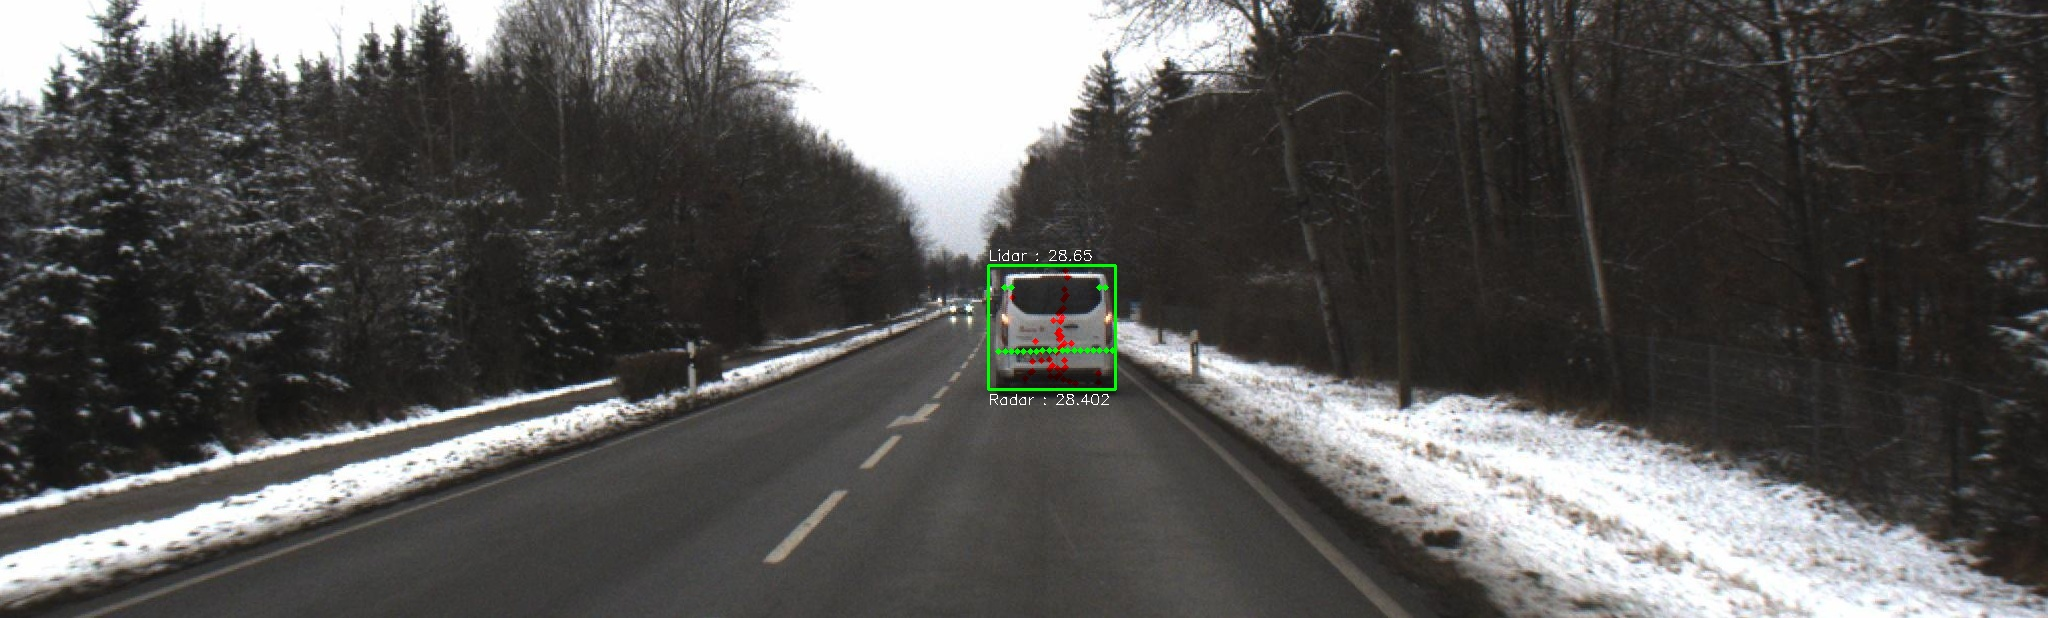

In [112]:
# Assuming blended_img_li_ra already contains the image
# Make a copy of the original image
blended_img_li_ra_copy = blended_img_li_ra.copy()

# Extract bounding box coordinates from DataFrame df
x_min = int(df.iloc[0, 0])  # Skip the first column of the index
y_min = int(df.iloc[0, 1])
x_max = int(df.iloc[0, 2])
y_max = int(df.iloc[0, 3])

# Draw the bounding box on the copy of the image
color = (0, 255, 0)  # Green color for the bounding box
thickness = 2  # Thickness of the bounding box
cv2.rectangle(blended_img_li_ra_copy, (x_min, y_min), (x_max, y_max), color, thickness)


# Add the median values to the copy image
text_lidar = f"Lidar : {x_lidar_mode_rounded}"
text_radar = f"Radar : {x_radar_mode_rounded}"
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.5
text_color = (255, 255, 255)  # White color for the text
thickness = 1

text_position_lidar = (x_min, y_min - 5)  # Position the Lidar text above the bounding box
text_position_radar = (x_min, y_max  + 15)  # Position the Radar text below the bounding box
cv2.putText(blended_img_li_ra_copy, text_lidar, text_position_lidar, font, font_scale, text_color, thickness)
cv2.putText(blended_img_li_ra_copy, text_radar, text_position_radar, font, font_scale, text_color, thickness)

# Convert the copy image to a format compatible with the Image object
img_bytes_copy = cv2.imencode('.jpg', blended_img_li_ra_copy)[1].tobytes()

# Display the copy image
display(Image(data=img_bytes_copy))

In [121]:
import numpy as np

class KalmanFilter:
    def __init__(self, initial_state_estimate, initial_estimate_covariance, process_noise_covariance, measurement_noise_covariance):
        self.state_estimate = initial_state_estimate
        self.estimate_covariance = initial_estimate_covariance
        self.process_noise_covariance = process_noise_covariance
        self.measurement_noise_covariance = measurement_noise_covariance

    def predict(self):
        # Predict next state based on process model
        # In a simple example, we can assume a constant velocity model
        # Here, we just update the state estimate without considering any process noise
        # You may need to refine this based on your specific system dynamics
        # For example, you could use a more complex state transition model
        pass

    def update(self, measurement):
        # Update state estimate based on measurement
        # Here, we assume a simple case where we directly use the measurement as the updated state
        # You may need to refine this based on your measurement model and Kalman gain calculation
        # For example, you could incorporate the mode of both Lidar and radar measurements
        self.state_estimate = measurement

# Assuming you have already calculated the mode for Lidar and radar measurements
mode_lidar = 28.72  # Example Lidar mode
mode_radar = 29.174068133390428  # Example radar mode

# Initial state estimate (you can initialize it with the mode of Lidar or radar, or a combination)
initial_state_estimate = (mode_lidar + mode_radar) / 2

# Initial estimate covariance (you may need to tune this based on your system)
initial_estimate_covariance = np.eye(1)  # Assuming a scalar state variable

# Process noise covariance (you may need to tune this based on your system)
process_noise_covariance = np.eye(1)  # Assuming a scalar state variable

# Measurement noise covariance (you may need to tune this based on your sensors)
measurement_noise_covariance = np.eye(1)  # Assuming a scalar measurement variable

# Create Kalman filter object
kalman_filter = KalmanFilter(initial_state_estimate, initial_estimate_covariance, process_noise_covariance, measurement_noise_covariance)
distance_radar= com_radar[:,0]
distance_lidar= com_lidar[:,0]
# Iterate through measurements and update Kalman filter
for measurement in zip(distance_lidar, distance_radar):
    # Predict next state
    kalman_filter.predict()

    # Update state based on measurement
    kalman_filter.update((measurement[0] + measurement[1]) / 2)  # Average of Lidar and radar measurements

    # Get estimated distance from Kalman filter
    estimated_distance = kalman_filter.state_estimate

    # Compare with ground truth or perform further analysis
print(estimated_distance)


28.999790252826344
